<a href="https://colab.research.google.com/github/sv650s/amazon-review-classification/blob/master/notebooks/deep_learning/3.0-LSTM16-prototype.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LSTM 16 Cell Prototype - Unbalanced Weights

* 1 Layer LSTM architecture with 16 cells
* Fully connected layer with softmax output of 5

In [1]:
from google.colab import drive
drive.mount('/content/drive')

import sys
DRIVE_DIR = "drive/My Drive/Springboard/capstone"
sys.path.append(DRIVE_DIR)


%tensorflow_version 2.x


import tensorflow as tf
# checl to make sure we are using GPU here
tf.test.gpu_device_name()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


'/device:GPU:0'

In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Embedding, \
    SpatialDropout1D, Flatten, LSTM
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.utils import model_to_dot

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report

import pandas as pd
from IPython.display import SVG
import pickle
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import os
import logging
import numpy as np


import util.dict_util as du
import util.plot_util as pu
import util.file_util as fu
import util.keras_util as ku
import util.report_util as ru

import random

# fix random seeds
RSTATE = 1
tf.compat.v1.reset_default_graph()
tf.compat.v1.set_random_seed(RSTATE)
random.seed(RSTATE)
np.random.seed(RSTATE)


logging.basicConfig(level=logging.ERROR)

%matplotlib inline
sns.set()


DATE_FORMAT = '%Y-%m-%d'
TIME_FORMAT = '%Y-%m-%d %H:%M:%S'
LABEL_COLUMN = "star_rating"
FEATURE_COLUMN = "review_body"


DEBUG = False


SAMPLES = "200k"
LSTM_DIM = 16 # total LSTM units
REPORT_FILE = "dl_prototype-report.csv"

# length of our embedding - 300 is standard
EMBED_SIZE = 300
EPOCHS  = 20
BATCH_SIZE = 128
LEARNING_RATE = 0.01
DROPOUT_RATE = 0.0
RECURRENT_DROPOUT_RATE = 0.0


# From EDA, we know that 90% of review bodies have 100 words or less, 
# we will use this as our sequence length
MAX_SEQUENCE_LENGTH = 100


MODEL_NAME = f"LSTM{LSTM_DIM}"
ARCHITECTURE = f"1x{LSTM_DIM}"
DESCRIPTION = f"1 Layer {LSTM_DIM} LSTM Units, unbalanced weights"
FEATURE_SET_NAME = "random_embedding"
PATIENCE = 4


if DEBUG:
  DATA_FILE = f'{DRIVE_DIR}/data/amazon_reviews_us_Wireless_v1_00-test-preprocessed.csv'
  MODEL_NAME = f'test-{MODEL_NAME}'
  MISSING_WORDS_FILE = f'{DRIVE_DIR}/reports/glove_embedding-missing_words-test.csv'
  ku.ModelWrapper.set_report_filename(f'test-{REPORT_FILE}')
else:
  DATA_FILE = f"{DRIVE_DIR}/data/amazon_reviews_us_Wireless_v1_00-{SAMPLES}-with_stop_nonlemmatized-preprocessed.csv"
  MISSING_WORDS_FILE = f'{DRIVE_DIR}/reports/glove_embedding-missing_words-{SAMPLES}.csv'
  ku.ModelWrapper.set_report_filename(REPORT_FILE)


EMBEDDING_FILE = f'{DRIVE_DIR}/data/embeddings/glove.840B.300d.txt'


start_time = datetime.now()

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
df = pd.read_csv(DATA_FILE)

rating = df[LABEL_COLUMN]
reviews = df[FEATURE_COLUMN]

# Preprocessing

In [4]:


# pre-process our lables
# one hot encode our star ratings since Keras/TF requires this for the labels
y = OneHotEncoder().fit_transform(rating.values.reshape(len(rating), 1)).toarray()


# split our data into train and test sets
reviews_train, reviews_test, y_train, y_test = train_test_split(reviews, y, random_state=1)


# Pre-process our features (review body)
t = Tokenizer()
# fit the tokenizer on the documents
t.fit_on_texts(reviews_train)
# tokenize both our training and test data
train_sequences = t.texts_to_sequences(reviews_train)
test_sequences = t.texts_to_sequences(reviews_test)

print("Vocabulary size={}".format(len(t.word_counts)))
print("Number of Documents={}".format(t.document_count))


# pad our reviews to the max sequence length
X_train = sequence.pad_sequences(train_sequences, maxlen=MAX_SEQUENCE_LENGTH)
X_test = sequence.pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH)

print('Train review vectors shape:', X_train.shape, ' Test review vectors shape:', X_test.shape)


Vocabulary size=49573
Number of Documents=149653
Train review vectors shape: (149653, 100)  Test review vectors shape: (49885, 100)


**Build LSTM Model Architecture**

In [0]:
vocab_size = len(t.word_counts)+1

# building our network
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=EMBED_SIZE, input_length=MAX_SEQUENCE_LENGTH))
model.add(LSTM(LSTM_DIM, dropout = DROPOUT_RATE, recurrent_dropout= RECURRENT_DROPOUT_RATE))
model.add(Dense(5, activation="softmax"))

model.compile(loss="categorical_crossentropy", 
              optimizer=Adam(learning_rate=LEARNING_RATE),
              metrics=["categorical_accuracy"])


In [6]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 300)          14872200  
_________________________________________________________________
lstm (LSTM)                  (None, 16)                20288     
_________________________________________________________________
dense (Dense)                (None, 5)                 85        
Total params: 14,892,573
Trainable params: 14,892,573
Non-trainable params: 0
_________________________________________________________________
None


In [7]:

# reduce learning rate if we sense a plateau
reduce_lr = ReduceLROnPlateau(monitor='val_loss', 
                              restore_best_weights = True)

early_stop = EarlyStopping(monitor='val_loss', 
                           patience=PATIENCE, 
                           verbose=1,
                           restore_best_weights = True)

mw = ku.ModelWrapper(model, 
                     MODEL_NAME, 
                     ARCHITECTURE,
                     FEATURE_SET_NAME,
                     LABEL_COLUMN, 
                     FEATURE_COLUMN,
                     DATA_FILE, 
                     embed_size=EMBED_SIZE,
                     tokenizer=t,
                     description=DESCRIPTION)

network_history = mw.fit(X_train, y_train,
                      batch_size=BATCH_SIZE,
                      epochs=EPOCHS,
                      verbose=1,
                      validation_split=0.2,
                      callbacks=[early_stop, reduce_lr])

Number of training examples: 149653
Epoch 1/20
936/936 [==============================] - 95s 101ms/step - loss: 0.8881 - categorical_accuracy: 0.6540 - val_loss: 0.8351 - val_categorical_accuracy: 0.6743 - lr: 0.0100
Epoch 2/20
936/936 [==============================] - 94s 100ms/step - loss: 0.7874 - categorical_accuracy: 0.6909 - val_loss: 0.8548 - val_categorical_accuracy: 0.6698 - lr: 0.0100
Epoch 3/20
936/936 [==============================] - 94s 100ms/step - loss: 0.7465 - categorical_accuracy: 0.7078 - val_loss: 0.8751 - val_categorical_accuracy: 0.6626 - lr: 0.0100
Epoch 4/20
936/936 [==============================] - 94s 100ms/step - loss: 0.7242 - categorical_accuracy: 0.7168 - val_loss: 0.8903 - val_categorical_accuracy: 0.6594 - lr: 0.0100
Epoch 5/20
936/936 [==============================] - 94s 100ms/step - loss: 0.7099 - categorical_accuracy: 0.7246 - val_loss: 0.9074 - val_categorical_accuracy: 0.6551 - lr: 0.0100
Epoch 00005: early stopping


Number of test: 49885
Running model.evaluate...
1559/1559 [==============================] - 8s 5ms/step - loss: 0.8365 - categorical_accuracy: 0.6722
Running model.predict...
Unencode predictions...
Generating confusion matrix...
Calculating ROC AUC...
(49885, 5)
Getting classification report...
Accuracy: 67.22%


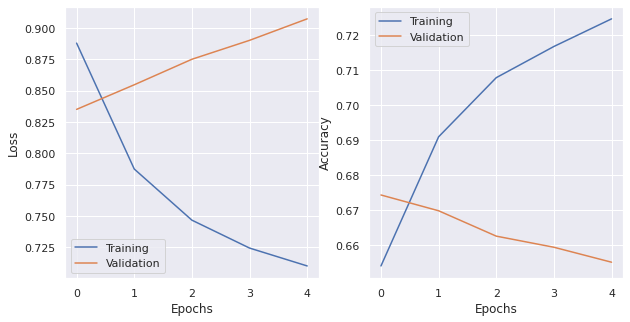


Confusion Matrix
[[ 5290   473   545   107   543]
 [ 1429   455   736   188   425]
 [  828   365  1525   740  1096]
 [  298   161  1050  1699  5160]
 [  445    77   506  1181 24563]]

Classification Report
              precision    recall  f1-score   support

           1       0.64      0.76      0.69      6958
           2       0.30      0.14      0.19      3233
           3       0.35      0.33      0.34      4554
           4       0.43      0.20      0.28      8368
           5       0.77      0.92      0.84     26772

    accuracy                           0.67     49885
   macro avg       0.50      0.47      0.47     49885
weighted avg       0.63      0.67      0.64     49885



drive/My Drive/Springboard/capstone/util/plot_util.py:267: MatplotlibDeprecationWarning: The 'withdash' parameter of text() is deprecated since Matplotlib 3.1 and will be removed in 3.3.  If any parameter follows 'withdash', they should be pass as keyword, not positionally.
  withdash=True)
drive/My Drive/Springboard/capstone/util/plot_util.py:267: MatplotlibDeprecationWarning: 
The TextWithDash class was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Annotation instead.
  withdash=True)
drive/My Drive/Springboard/capstone/util/plot_util.py:271: MatplotlibDeprecationWarning: The 'withdash' parameter of text() is deprecated since Matplotlib 3.1 and will be removed in 3.3.  If any parameter follows 'withdash', they should be pass as keyword, not positionally.
  withdash=True)
drive/My Drive/Springboard/capstone/util/plot_util.py:271: MatplotlibDeprecationWarning: 
The TextWithDash class was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Annotation instead.
  w

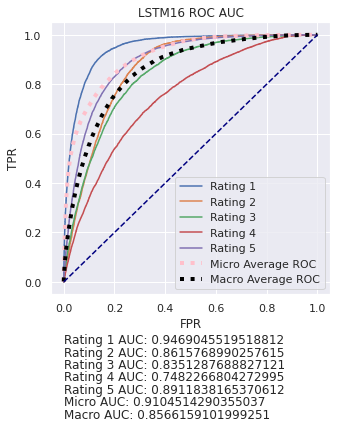

In [8]:

scores = mw.evaluate(X_test, y_test)
accuracy = mw.scores[1] * 100
print("Accuracy: %.2f%%" % accuracy)

pu.plot_network_history(mw.network_history, "categorical_accuracy", "val_categorical_accuracy")
plt.show()

print("\nConfusion Matrix")
print(mw.confusion_matrix)

print("\nClassification Report")
print(mw.classification_report)

fig = plt.figure(figsize=(5,5))
pu.plot_roc_auc(mw.model_name, mw.roc_auc, mw.fpr, mw.tpr)



In [9]:
score = ru.calculate_metric(mw.crd)
print('Score: %.2f%%' % score)

Score: 0.28%


**Save off various files**

In [10]:
mw.save(DRIVE_DIR, append_report=True)

description: LSTM16-1x16-random_embedding-sampling_none-199538-100-review_body
Saving to report file: drive/My Drive/Springboard/capstone//reports/dl_prototype-report.csv
Loading to append to: drive/My Drive/Springboard/capstone//reports/dl_prototype-report.csv
{'model_name': 'LSTM16', 'architecture': '1x16', 'description': '1 Layer 16 LSTM Units, unbalanced weights, High RAM GPU', 'feature_column': '{"1": {"precision": 0.638118214716526, "recall": 0.7602759413624605, "f1-score": 0.6938614900314796, "support": 6958}, "2": {"precision": 0.29719137818419333, "recall": 0.14073615836684195, "f1-score": 0.1910159529806885, "support": 3233}, "3": {"precision": 0.34961027051811094, "recall": 0.33487044356609574, "f1-score": 0.3420816509645581, "support": 4554}, "4": {"precision": 0.43397190293742016, "recall": 0.20303537284894838, "f1-score": 0.27664251404380036, "support": 8368}, "5": {"precision": 0.7727372825368861, "recall": 0.9174884207380846, "f1-score": 0.8389145989514849, "support": 2

Test Loading our model back and see if accuracy is the same

In [11]:
from tensorflow.keras.models import load_model

model_loaded = load_model(mw.model_file)
scores = model_loaded.evaluate(X_test, y_test, verbose=1)
print("Original Accuracy: % 2f%%" % accuracy)
print("Loaded Accuracy: %.2f%%" % (scores[1]*100))

# this takes too long for real models
if DEBUG == True:
  y_predict = model_loaded.predict(X_test)
  y_predict_unencoded = ku.unencode(y_predict)
  y_test_unencoded = ku.unencode(y_test)

  # classification report
  print(classification_report(y_test_unencoded, y_predict_unencoded))

  # confusion matrix
  print(confusion_matrix(y_test_unencoded, y_predict_unencoded))

1559/1559 [==============================] - 9s 6ms/step - loss: 0.8365 - categorical_accuracy: 0.6722
Original Accuracy:  67.218602%
Loaded Accuracy: 67.22%


In [12]:
end_time = datetime.now()
print("Accuracy: %.2f%%" % accuracy)
print('Custom Score: %.2f%%' % score)
print(f'Report filename: {ku.ModelWrapper.get_report_file_name(DRIVE_DIR, use_date=False)}')
print(f'Star Time: {start_time }\nEnd time: {end_time}\nTotal Duration: {round((end_time - start_time).total_seconds() / 60, 2)} mins')


Accuracy: 67.22%
Custom Score: 0.28%
Report filename: drive/My Drive/Springboard/capstone//reports/dl_prototype-report.csv
Star Time: 2020-05-01 15:23:13.039984
End time: 2020-05-01 15:32:13.831496
Total Duration: 9.01 mins
